# Recognition of book text.
---

In [135]:
import cv2
import numpy as np
import easyocr
import os
import matplotlib.pyplot as plt

import re
from difflib import SequenceMatcher
from transformers import TrOCRProcessor, VisionEncoderDecoderModel,ViTImageProcessor, RobertaTokenizer
from PIL import Image as PILImage
import torch

In [136]:
import nltk
from nltk.corpus import words, wordnet
from nltk.metrics.distance import edit_distance

# Download required NLTK resources
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [137]:
def initialize_trocr(model_name="microsoft/trocr-small-handwritten"):
    """Initialize TrOCR model for handwritten text recognition"""
    print(f"Loading TrOCR model: {model_name}")
    
    try:
        # Try loading with trust_remote_code=True and use_safetensors=True
        trocr_processor = TrOCRProcessor.from_pretrained(
            model_name,
            trust_remote_code=True,
            use_fast=False
        )
        
        trocr_model = VisionEncoderDecoderModel.from_pretrained(
            model_name,
            trust_remote_code=True,
            use_safetensors=True
        )

        if torch.cuda.is_available():
            trocr_model = trocr_model.to("cuda")
            print("TrOCR model loaded on GPU")
        else:
            print("TrOCR model loaded on CPU")
        
        return trocr_processor, trocr_model
    
    except Exception as e:
        print(f"Error loading TrOCR model: {e}")
        print("Falling back to direct loading method...")
        try:
            image_processor = ViTImageProcessor.from_pretrained(model_name)
            tokenizer = RobertaTokenizer.from_pretrained(model_name)

            class CustomTrOCRProcessor:
                def __init__(self, image_processor, tokenizer):
                    self.image_processor = image_processor
                    self.tokenizer = tokenizer
                
                def __call__(self, images, **kwargs):
                    return self.image_processor(images, **kwargs)
                
                def batch_decode(self, *args, **kwargs):
                    return self.tokenizer.batch_decode(*args, **kwargs)
            
            custom_processor = CustomTrOCRProcessor(image_processor, tokenizer)
            model = VisionEncoderDecoderModel.from_pretrained(model_name)
            
            if torch.cuda.is_available():
                model = model.to("cuda")
                print("TrOCR model loaded on GPU (using custom loading)")
            else:
                print("TrOCR model loaded on CPU (using custom loading)")
            
            return custom_processor, model
        
        except Exception as e2:
            print(f"Failed to load TrOCR with alternative method: {e2}")
            print("TrOCR will not be available - using EasyOCR only")
            return None, None

### IMAGE PROCESSING PIPELINE.
---

In [138]:
def adaptive_post_process(text):
    english_words = set(words.words())
    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'(\d+)\s+(\d+)', r'\1\2', text)

    common_fixes = [
        (r'\bI\s+he\b', 'The'),  
        (r'\blo\b', 'to'),      
        (r'\bl\b', '1'),        
        (r'\bO\b', '0'),         
        (r'\s+,\s+', ', ')      
    ]
    
    for pattern, replacement in common_fixes:
        text = re.sub(pattern, replacement, text)

    words_list = text.split()
    result_words = []
    
    for word in words_list:
        # Skip short words, numbers, punctuation
        if len(word) <= 2 or word.isdigit() or not any(c.isalpha() for c in word):
            result_words.append(word)
            continue

        if word.lower() not in english_words and not word.isupper(): 
            result_words.append(word)
        else:
            result_words.append(word)
    
    # Reassemble text
    return ' '.join(result_words)

In [139]:
def deskew(image):
    # Find all non-zero points
    coords = np.column_stack(np.where(image > 0))
    
    # Need at least 3 points for minAreaRect
    if len(coords) < 3:
        return image
    
    # Get the minimum area rectangle
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    
    # Adjust angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
        
    # Rotate the image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), 
                            flags=cv2.INTER_CUBIC, 
                            borderMode=cv2.BORDER_REPLICATE)
    return rotated          

In [140]:
def enhance_contrast(image):
    """Enhance contrast using CLAHE"""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def remove_noise(image):
    """Remove noise using morphological operations"""
    kernel = np.ones((2, 2), np.uint8)
    denoised = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    denoised = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)
    return denoised

In [141]:
def preprocess_image(image_path, save_intermediate=True):
    """Apply preprocessing pipeline to improve OCR results"""
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create output directory for intermediate results
    if save_intermediate:
        output_dir = "preprocessed_steps"
        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(os.path.join(output_dir, '1_original.jpg'), image)
        cv2.imwrite(os.path.join(output_dir, '2_grayscale.jpg'), gray)
    
    # Enhance contrast using CLAHE
    enhanced = enhance_contrast(gray)
    if save_intermediate:
        cv2.imwrite(os.path.join(output_dir, '3_enhanced.jpg'), enhanced)

    thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY_INV, 11, 2)
    if save_intermediate:
        cv2.imwrite(os.path.join(output_dir, '4_threshold.jpg'), thresh)
        
    denoised = remove_noise(thresh)
    if save_intermediate:
        cv2.imwrite(os.path.join(output_dir, '5_denoised.jpg'), denoised)

    deskewed = deskew(denoised)
    if save_intermediate:
        cv2.imwrite(os.path.join(output_dir, '6_deskewed.jpg'), deskewed)
    
    final = cv2.bitwise_not(deskewed)
    if save_intermediate:
        cv2.imwrite(os.path.join(output_dir, '7_final.jpg'), final)
    
    simple_thresh = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    simple_final = cv2.bitwise_not(simple_thresh)
    if save_intermediate:
        cv2.imwrite(os.path.join(output_dir, '8_simple_final.jpg'), simple_final)
    
    return {
        'original': image,
        'grayscale': gray,
        'enhanced': enhanced,
        'threshold': thresh,
        'denoised': denoised,
        'deskewed': deskewed,
        'final': final,
        'simple_final': simple_final
    }

In [142]:
def display_preprocessing_steps(preprocessed_images):
    """Display all preprocessing steps"""
    plt.figure(figsize=(20, 15))
    
    steps = [
        ('Original', 'original', cv2.COLOR_BGR2RGB),
        ('Grayscale', 'grayscale', None),
        ('Enhanced Contrast', 'enhanced', None),
        ('Adaptive Threshold', 'threshold', None),
        ('Noise Removal', 'denoised', None),
        ('Deskewed', 'deskewed', None),
        ('Final (Inverted)', 'final', None),
        ('Simple Threshold', 'simple_final', None)
    ]
    
    for i, (title, key, color_conversion) in enumerate(steps):
        plt.subplot(2, 4, i+1)
        img = preprocessed_images[key]
        
        if color_conversion:
            img = cv2.cvtColor(img, color_conversion)
            
        plt.imshow(img, cmap='gray' if color_conversion is None else None)
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### OCR MODELS.
----

In [143]:
def run_trocr(image_path, processor=None, model=None):
    if processor is None or model is None:
        print("TrOCR not available, skipping")
        return None
    
    try:
        # Open image with PIL
        image = PILImage.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        if torch.cuda.is_available():
            pixel_values = pixel_values.to("cuda")

        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        print(f"TrOCR result: {generated_text}")
        
        return {
            'text': generated_text,
            'confidence': 0.9,  
            'method': 'trocr'
        }
    except Exception as e:
        print(f"TrOCR error: {e}")
        return None

In [144]:
def run_ocr(image, settings=None):
    """Run OCR with specified settings"""
    if settings is None:
        settings = {'decoder': 'beamsearch', 'beamWidth': 5, 'paragraph': True, 'text_threshold': 0.5}
    
    reader = easyocr.Reader(['en'])
    results = reader.readtext(image, **settings)
    
    if results:
        text = " ".join([item[1] for item in results])
        confidence = np.mean([item[2] for item in results])
        return {
            'text': text,
            'confidence': confidence,
            'raw_results': results
        }
    return None

def try_multiple_ocr_settings(image):
    """Try multiple OCR settings and return the best result"""
    settings_list = [
        {'decoder': 'greedy', 'paragraph': False, 'text_threshold': 0.7},
        {'decoder': 'beamsearch', 'beamWidth': 5, 'paragraph': True, 'text_threshold': 0.5},
        {'decoder': 'beamsearch', 'beamWidth': 10, 'paragraph': True, 'text_threshold': 0.4}
    ]
    
    results = []
    
    for i, settings in enumerate(settings_list):
        print(f"Running OCR with setting {i+1}/{len(settings_list)}...")
        try:
            result = run_ocr(image, settings)
            if result:
                result['settings'] = settings
                results.append(result)
                print(f"  Confidence: {result['confidence']:.2f}")
                print(f"  Text: {result['text'][:50]}..." if len(result['text']) > 50 else f"  Text: {result['text']}")
        except Exception as e:
            print(f"  Error with setting {i+1}: {e}")
    
    if results:
        return max(results, key=lambda x: x['confidence'])
    return None

In [145]:
def visualize_ocr_results(image, results):
    vis_img = image.copy()

    if len(vis_img.shape) == 2:
        vis_img = cv2.cvtColor(vis_img, cv2.COLOR_GRAY2BGR)

    if 'raw_results' in results:
        for (bbox, text, prob) in results['raw_results']:
            points = np.array(bbox, np.int32)
            points = points.reshape((-1, 1, 2))

            cv2.polylines(vis_img, [points], True, (0, 255, 0), 2)
            
            # Add text and confidence
            x, y = bbox[0]
            cv2.putText(vis_img, f"{text} ({prob:.2f})", (int(x), int(y) - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    else:
        cv2.putText(vis_img, f"TrOCR: {results.get('text', 'No text')}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"OCR Results - Method: {results.get('method', 'Unknown')}")
    plt.show()  

In [146]:
def post_process_with_nltk(text):
    """Improve OCR results using NLTK language processing"""
    # Get English word set
    english_words = set(words.words())
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    corrected_tokens = []
    
    for token in tokens:
        if len(token) <= 2 or token.isdigit() or not any(c.isalpha() for c in token):
            corrected_tokens.append(token)
            continue
        if token.lower() in english_words:
            corrected_tokens.append(token)
            continue
        
        # Find closest word by edit distance
        candidates = []
        for word in english_words:
            if abs(len(word) - len(token)) <= 2:
                distance = edit_distance(token.lower(), word)
                # Only consider close matches
                if distance <= 2:
                    candidates.append((word, distance))
        candidates.sort(key=lambda x: x[1])

        if candidates and candidates[0][1] <= 2:
            corrected_tokens.append(candidates[0][0])
        else:
            synsets = wordnet.synsets(token)
            if synsets:
                # Use the name from the first synset
                corrected_tokens.append(synsets[0].name().split('.')[0])
            else:
                corrected_tokens.append(token)

    corrected_text = ' '.join(corrected_tokens)

    patterns = [
        (r'\b(\d+)\s+(\d+)\b', r'\1\2'),  
        (r'\bclass\s+l\b', r'class 1'),    
        (r'\bthe\s+the\b', r'the'),        
    ]
    
    for pattern, replacement in patterns:
        corrected_text = re.sub(pattern, replacement, corrected_text)
    
    return corrected_text

In [147]:
def process_handwritten_image(image_path):
    """Process a handwritten image with improved preprocessing and OCR"""
    print(f"Processing image: {image_path}")

    print("Applying preprocessing...")
    preprocessed_images = preprocess_image(image_path)

    display_preprocessing_steps(preprocessed_images)

    output_dir = "ocr_input"
    os.makedirs(output_dir, exist_ok=True)
    
    final_path = os.path.join(output_dir, 'final_preprocessed.jpg')
    simple_path = os.path.join(output_dir, 'simple_preprocessed.jpg')
    
    cv2.imwrite(final_path, preprocessed_images['final'])
    cv2.imwrite(simple_path, preprocessed_images['simple_final'])
    
    print("\nRunning EasyOCR on advanced preprocessed image:")
    final_results = try_multiple_ocr_settings(final_path)
    
    print("\nRunning EasyOCR on simple preprocessed image:")
    simple_results = try_multiple_ocr_settings(simple_path)
    
    # Compare results and select the best
    if final_results and simple_results:
        if final_results['confidence'] > simple_results['confidence']:
            best_results = final_results
            best_image = preprocessed_images['final']
            print("\nAdvanced preprocessing produced better results.")
        else:
            best_results = simple_results
            best_image = preprocessed_images['simple_final']
            print("\nSimple preprocessing produced better results.")
    elif final_results:
        best_results = final_results
        best_image = preprocessed_images['final']
        print("\nOnly advanced preprocessing produced results.")
    elif simple_results:
        best_results = simple_results
        best_image = preprocessed_images['simple_final']
        print("\nOnly simple preprocessing produced results.")
    else:
        print("\nOCR failed to produce any valid results.")
        return
    
    # Original text from EasyOCR
    original_text = best_results['text']

    # Run TrOCR on the same image
    print("\nRunning TrOCR on the image...")
    trocr_path = os.path.join(output_dir, 'final_preprocessed.jpg')
    trocr_result = run_trocr(trocr_path)

    if trocr_result:
        print(f"TrOCR detected: {trocr_result['text']}")
        
        # Compare confidence (TrOCR assumed to be better for handwriting)
        print("\nComparing EasyOCR and TrOCR results...")
        print(f"EasyOCR confidence: {best_results['confidence']:.2f}")
        print(f"Using TrOCR result for handwritten text")
        
        # Use adaptive post-processing - no fixed corrections dictionary
        trocr_text = trocr_result['text']
        corrected_text = adaptive_post_process(trocr_text)
        
        # Set method for tracking
        method = "trocr"
    else:
        print("TrOCR failed, falling back to EasyOCR with NLTK post-processing")
        corrected_text = post_process_with_nltk(original_text)
        method = "easyocr+nltk"

    # Update results with corrected text
    best_results['original_text'] = original_text
    best_results['trocr_text'] = trocr_result['text'] if trocr_result else None
    best_results['text'] = corrected_text
    best_results['method'] = method
    
    print("\nBest OCR Result:")
    print("-" * 50)
    print(f"Method used: {best_results.get('method', 'easyocr')}")
    print(f"Confidence: {best_results['confidence']:.2f}")
    print(f"Original EasyOCR: {original_text}")
    if best_results.get('trocr_text'):
        print(f"TrOCR Text: {best_results['trocr_text']}")
    print(f"Final Text: {corrected_text}")
    print("-" * 50)
    
    visualize_ocr_results(best_image, best_results)
    
    result_path = os.path.join(output_dir, 'ocr_result.txt')
    with open(result_path, 'w') as f:
        f.write(corrected_text)
    
    print(f"Result saved to: {result_path}")
    
    return best_results

In [148]:
def run_original_ocr(image_path):
    """Run OCR without preprocessing for comparison"""
    print("\nRunning OCR on original image (without preprocessing):")
    reader = easyocr.Reader(['en'])
    
    try:
        results = reader.readtext(image_path)
        
        if results:
            text = " ".join([item[1] for item in results])
            confidence = np.mean([item[2] for item in results])
            
            print("\nOriginal OCR Result:")
            print("-" * 50)
            print(f"Confidence: {confidence:.2f}")
            print(f"Text: {text}")
            print("-" * 50)
            
            return {
                'text': text,
                'confidence': confidence,
                'raw_results': results
            }
    except Exception as e:
        print(f"Error with original OCR: {e}")
    
    return None


## RESULT DISPLAY SECTION.
---

Processing image: ../datasets/Page_Level_Test_Set/image.png
Applying preprocessing...


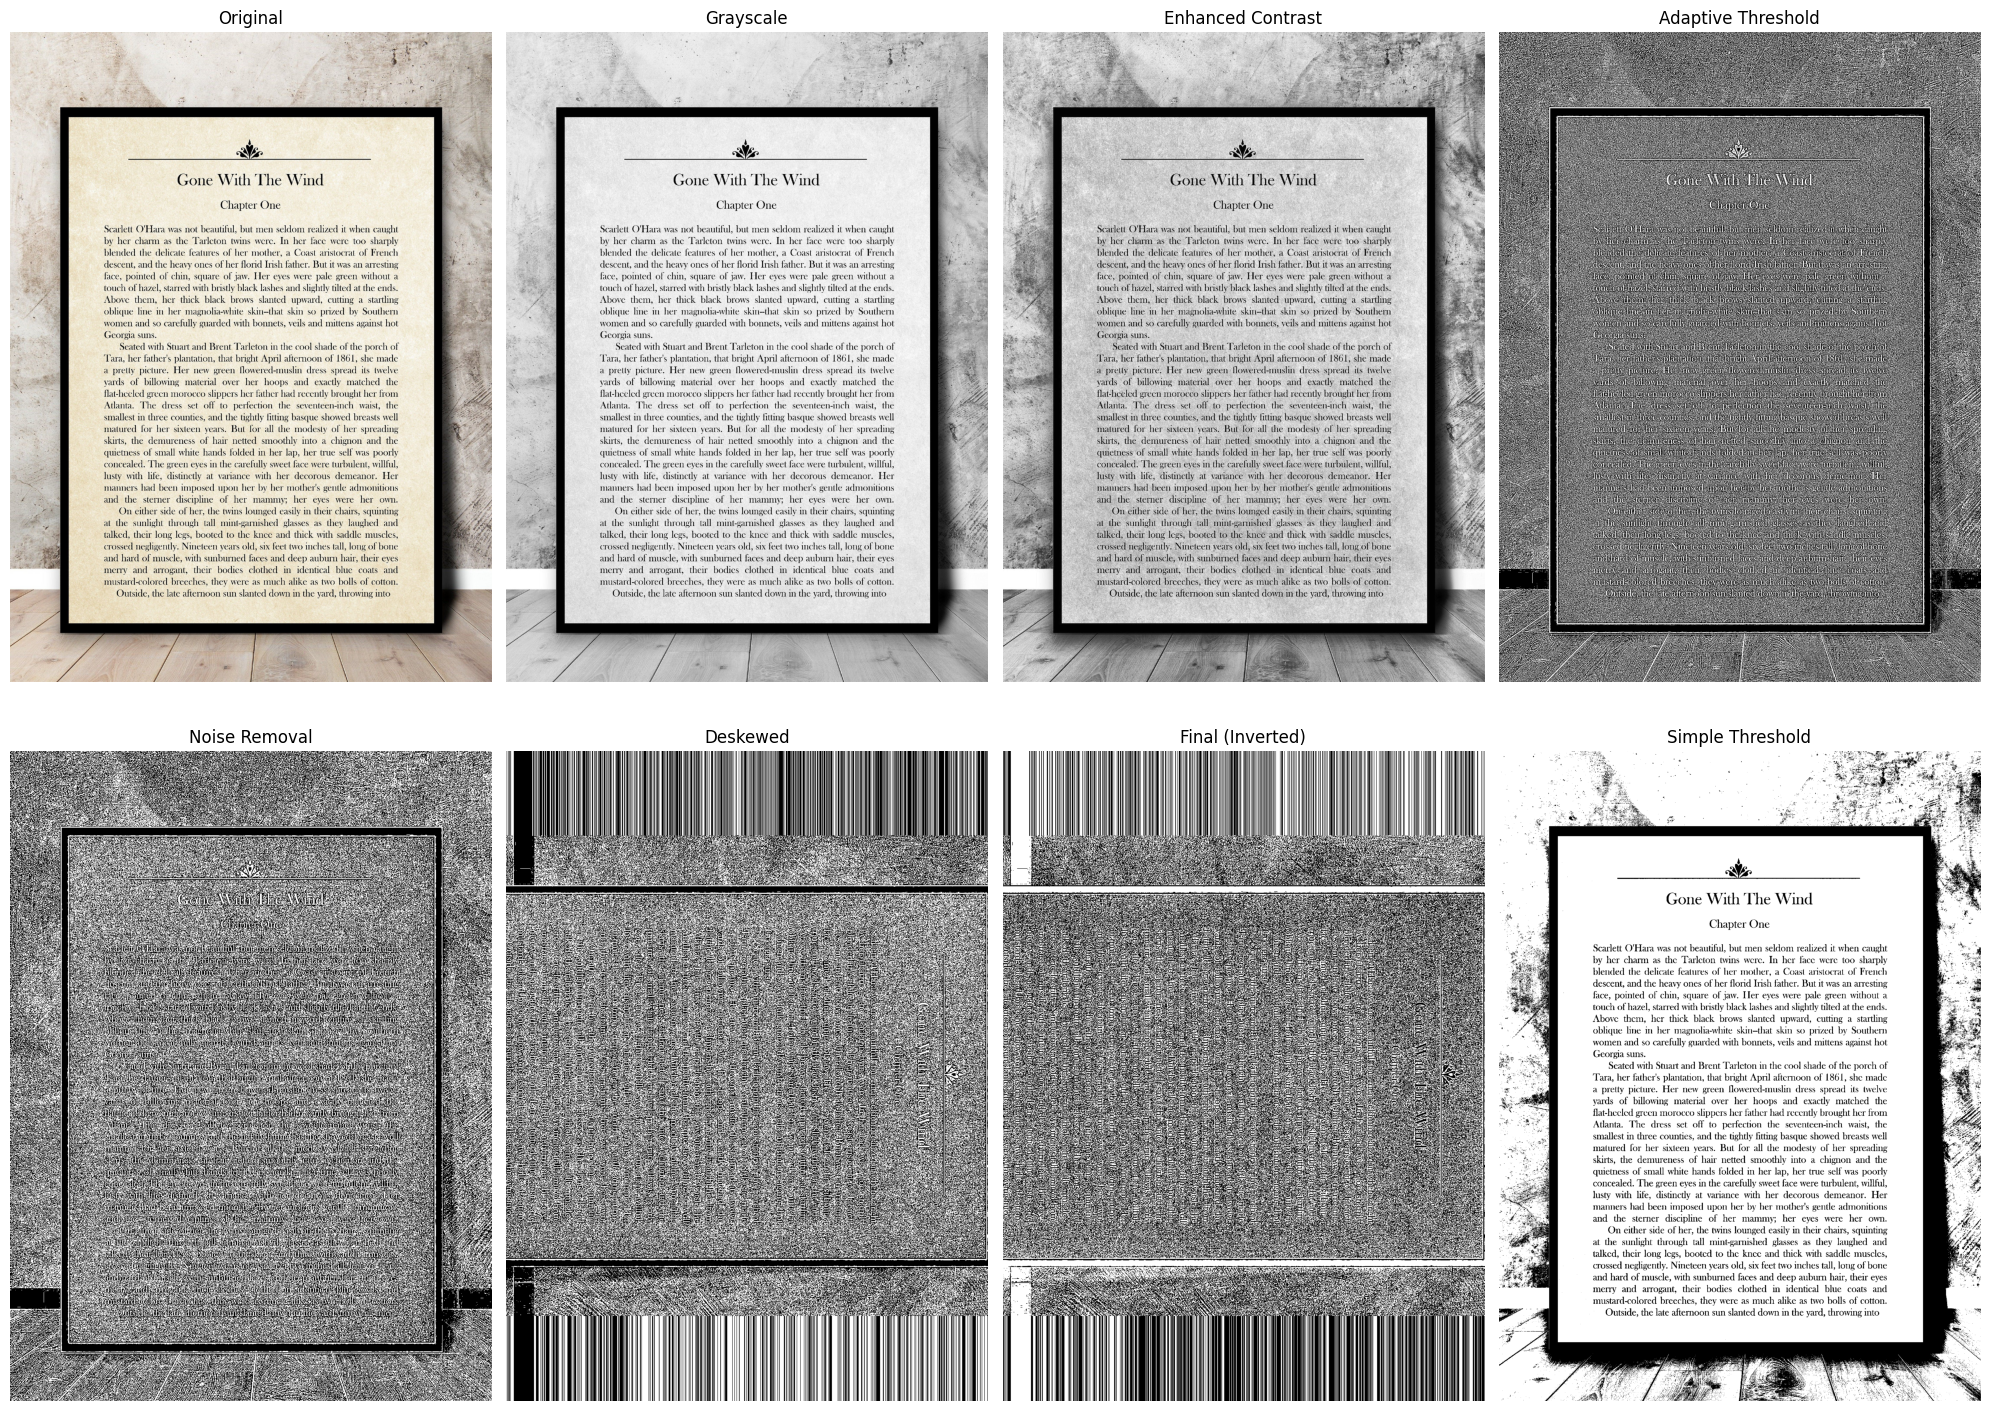

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



Running EasyOCR on advanced preprocessed image:
Running OCR with setting 1/3...


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


  Confidence: 0.14
  Text: 5
Running OCR with setting 2/3...


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


  Error with setting 2: list index out of range
Running OCR with setting 3/3...


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


  Error with setting 3: list index out of range

Running EasyOCR on simple preprocessed image:
Running OCR with setting 1/3...


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


  Confidence: 0.80
  Text: Gone With The Wind Chapter One Scarlett O'Hara was...
Running OCR with setting 2/3...


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


  Error with setting 2: list index out of range
Running OCR with setting 3/3...
  Error with setting 3: list index out of range

Simple preprocessing produced better results.

Running TrOCR on the image...
TrOCR not available, skipping
TrOCR failed, falling back to EasyOCR with NLTK post-processing

Best OCR Result:
--------------------------------------------------
Method used: easyocr+nltk
Confidence: 0.80
Original EasyOCR: Gone With The Wind Chapter One Scarlett O'Hara was not beautiful, but men seldom realized it when caught by hcr charm as thc Tarlcton twins wcrc In hcr facc wcrc too sharply blencled thie delicate fealures o her mother; a Coasl aristocral ol French descent; and the heavy ones of her florid Irish father. But it was an arresting face, pointed of chin; square of jaw: Iler eyes were pale green without a touch of hazel, starred with bristly black lashes and slightly tilted at the ends. Abovc   thcm, hcr thick   black   brows   slantcd upward; cutting a startling obliqu

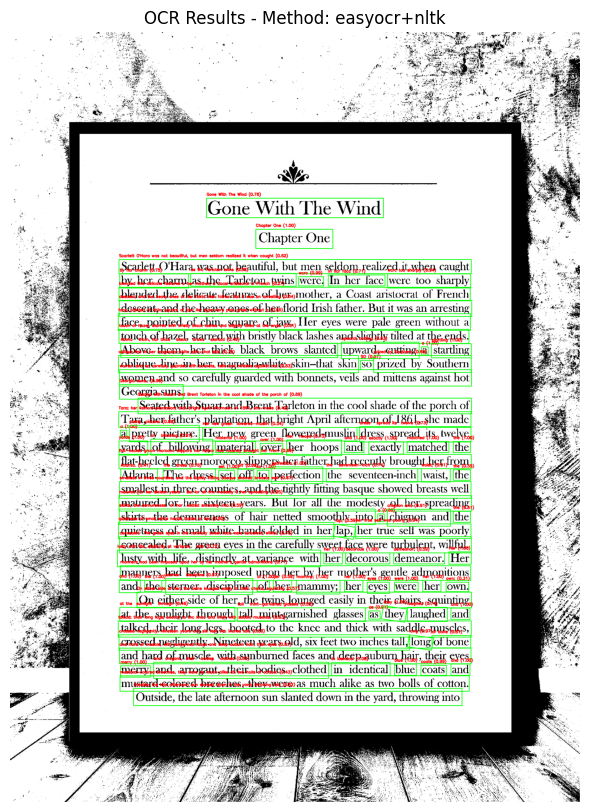

Result saved to: ocr_input\ocr_result.txt


In [149]:
image_path = "../datasets/Page_Level_Test_Set/image.png"
results = process_handwritten_image(image_path)

In [150]:
# Compare original EasyOCR with the enhanced results
original_results = run_original_ocr(image_path)

if results and original_results:
    print("\nComparison of All OCR Results:")
    print("-" * 50)
    print(f"Original EasyOCR Confidence: {original_results['confidence']:.2f}")
    
    if results.get('method', '').startswith('trocr'):
        print(f"TrOCR Used: Yes (confidence score approximated)")
    else:
        print(f"Enhanced EasyOCR Confidence: {results.get('confidence', 0):.2f}")
        print(f"Improvement: {(results.get('confidence', 0) - original_results['confidence']) * 100:.2f}%")
    
    print("-" * 50)
    print("1. Original EasyOCR Text:")
    print(original_results['text'])
    print("-" * 50)
    print("2. Enhanced System Text (Original):")
    print(results.get('original_text', 'N/A'))
    print("-" * 50)
    print("3. Enhanced System Text (Corrected):")
    print(results.get('text', 'N/A'))
    print("-" * 50)
    
    def similarity_ratio(a, b):
        return SequenceMatcher(None, a, b).ratio()
    
    orig_to_enhanced = similarity_ratio(original_results['text'], results.get('text', ''))
    print(f"Text Similarity - Original to Enhanced: {orig_to_enhanced:.2f}")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



Running OCR on original image (without preprocessing):

Original OCR Result:
--------------------------------------------------
Confidence: 0.82
Text: Gone With The Wind Chapter One Scarlett O'Hara was not beautiful, but men seldom realized it when caught by hcr charm as thc Tarlcton twins wcrc . In hcr facc wcrc too sharply blencledl the delicate fealures of her mother; a Coast aristocrat o French descent; and the heavy ones of her florid Irish father. But it was an atresting face, pointed of chin; square of jaw Iler eyes were pale green without a touch of hazel, starred with bristly black lashes and slightly tilted at the ends. Above   them; her thick black brows   slanted   upward, cutting a startling oblique line in her magnolia-white skin-that skin So prized by Southern women and so carefully guarded with bonnets, veils and mittens against hot Georgia suns Seated with Stuart and Brent Tarleton in the cool shade of the porch of Tara, her father's plantation, that bright April afte